In [4]:
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from Temp import multinomial_logistic_regression
import numpy as np


X, y = fetch_openml('mnist_784', version=1, return_X_y=True, as_frame=False)
X, y = X.astype(int), np.array(y, dtype=int)


X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=0, stratify=y
)

scaler = StandardScaler()
pca = PCA(n_components=300) 

X_train_proc = scaler.fit_transform(X_train)
X_train_proc = pca.fit_transform(X_train_proc)
X_test_proc = pca.transform(scaler.transform(X_test))


param_grid = {      
    'eta': [0.01, 0.1],               
    'hidden_layers': [[100], [50, 50, 50]], 
    'batch_size': [4096],           
    'max_iter': [2000] 
}

model = multinomial_logistic_regression(
    early_stopping=True,
    tol=1e-4,
    patience=20,
    validation_fraction=0.1,
    verbose=0 
)

rs = RandomizedSearchCV(
    estimator=model, 
    param_distributions=param_grid,
    n_iter=4,
    cv=3,
    verbose=2,
    n_jobs=None 
)

model = rs.fit(X_train_proc, y_train).best_estimator_


Fitting 3 folds for each of 4 candidates, totalling 12 fits
[CV] END batch_size=4096, eta=0.01, hidden_layers=[100], max_iter=2000; total time= 1.6min
[CV] END batch_size=4096, eta=0.01, hidden_layers=[100], max_iter=2000; total time= 1.6min
[CV] END batch_size=4096, eta=0.01, hidden_layers=[100], max_iter=2000; total time= 1.6min
[CV] END batch_size=4096, eta=0.01, hidden_layers=[50, 50, 50], max_iter=2000; total time= 1.5min
[CV] END batch_size=4096, eta=0.01, hidden_layers=[50, 50, 50], max_iter=2000; total time= 1.5min
[CV] END batch_size=4096, eta=0.01, hidden_layers=[50, 50, 50], max_iter=2000; total time= 1.5min
[CV] END batch_size=4096, eta=0.1, hidden_layers=[100], max_iter=2000; total time= 1.7min
[CV] END batch_size=4096, eta=0.1, hidden_layers=[100], max_iter=2000; total time= 1.6min
[CV] END batch_size=4096, eta=0.1, hidden_layers=[100], max_iter=2000; total time= 1.6min
[CV] END batch_size=4096, eta=0.1, hidden_layers=[50, 50, 50], max_iter=2000; total time= 1.5min
[CV] E

In [5]:

print(f"Best:\n{rs.best_params_}")

Best:
{'max_iter': 2000, 'hidden_layers': [100], 'eta': 0.1, 'batch_size': 4096}


In [7]:
y_pred = model.predict(X_test_proc)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.98      0.97      2071
           1       0.98      0.99      0.98      2363
           2       0.96      0.96      0.96      2097
           3       0.96      0.95      0.96      2142
           4       0.96      0.96      0.96      2047
           5       0.96      0.95      0.96      1894
           6       0.97      0.98      0.97      2063
           7       0.97      0.97      0.97      2188
           8       0.96      0.95      0.95      2048
           9       0.95      0.94      0.95      2087

    accuracy                           0.96     21000
   macro avg       0.96      0.96      0.96     21000
weighted avg       0.96      0.96      0.96     21000


In [9]:
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, matthews_corrcoef
y_pred = model.predict(X_test_proc)
perf =f"\
    Multinomial Logistic Regression\
    \nAccuracy: {accuracy_score(y_test, y_pred):.4f}, \
    Precision: {precision_score(y_test, y_pred, average='weighted'):.4f}, \
    Recall: {recall_score(y_test, y_pred,average='weighted'):.4f}, \
    F1: {f1_score(y_test, y_pred,average='weighted'):.4f}, \
    MCC: {matthews_corrcoef(y_test, y_pred):.4f}"

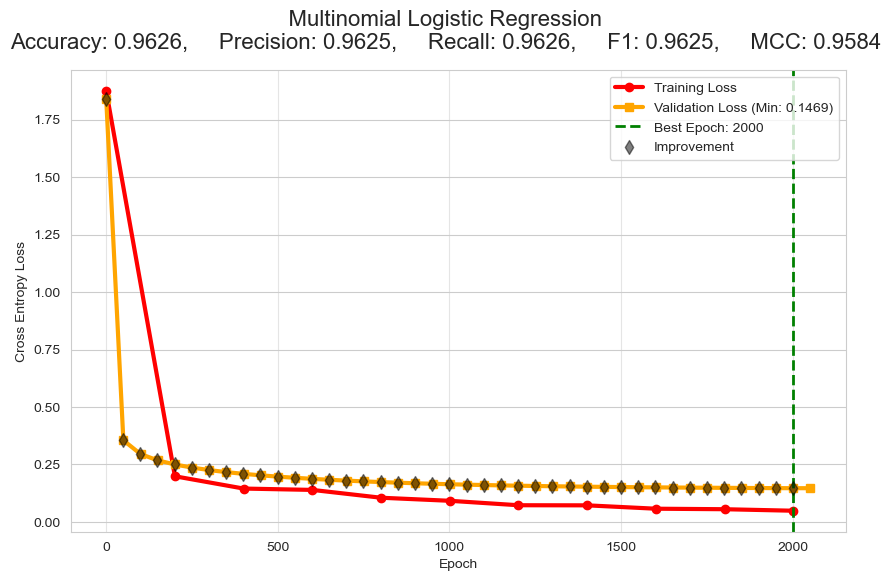

In [22]:
import numpy as np
import matplotlib.pyplot as plt

clf = model

scope = 200
fig, ax = plt.subplots(figsize=(10, 6))

if 'perf' in locals():
    fig.suptitle(perf, fontsize=16)

training_losses_cpu = [x.item() if hasattr(x, 'item') else x for x in clf.losses]

t_x = np.arange(1, len(training_losses_cpu) + 1, scope)
t_y = training_losses_cpu[::scope]

if len(training_losses_cpu) > 0 and t_x[-1] != len(training_losses_cpu):
    t_x = np.append(t_x, len(training_losses_cpu))
    t_y = np.append(t_y, training_losses_cpu[-1])

plot_data = [
    {
        "x": t_x,
        "y": t_y,
        "label": "Training Loss",
        "color": "red",
        "marker": "o"
    }
]

if hasattr(clf, 'val_losses') and len(clf.val_losses) > 0:
    losses_cpu = [x.item() if hasattr(x, 'item') else x for x in clf.val_losses]
    
    v_x = np.arange(0, len(losses_cpu) *50,50)+1
    v_y = losses_cpu[::]
    
    if v_x[-1] != len(losses_cpu):
        v_x = np.append(v_x, len(losses_cpu)*50+1)
        v_y = np.append(v_y, losses_cpu[-1])

    min_val = np.min(losses_cpu)
    plot_data.append({
        "x": v_x,
        "y": v_y,
        "label": f"Validation Loss (Min: {min_val:.4f})",
        "color": "orange",
        "marker": "s"
    })

for data in plot_data:
    ax.plot(data["x"], data["y"], 
            label=data["label"], color=data["color"], marker=data["marker"], lw=3)


if hasattr(clf, "hist_"):
    hist = []
    for epoch, loss in clf.hist_:
        l = loss.item() if hasattr(loss, 'item') else loss
        hist.append([epoch, l])
    hist = np.array(hist)
    
    if hasattr(clf, "best_epoch_") and hist.ndim == 2 and hist.shape[0] > 0:
        ax.axvline(clf.best_epoch_, color='green', label=f'Best Epoch: {clf.best_epoch_}', linestyle='--', lw=2)
        ax.scatter(hist[:, 0], hist[:, 1], c="k", label="Improvement", marker='d', s=50, zorder=5, alpha=0.5)

ax.set_xlabel("Epoch")
ax.set_ylabel("Cross Entropy Loss")
ax.grid(axis="x", alpha=0.5)
ax.legend(loc="upper right")

plt.show()

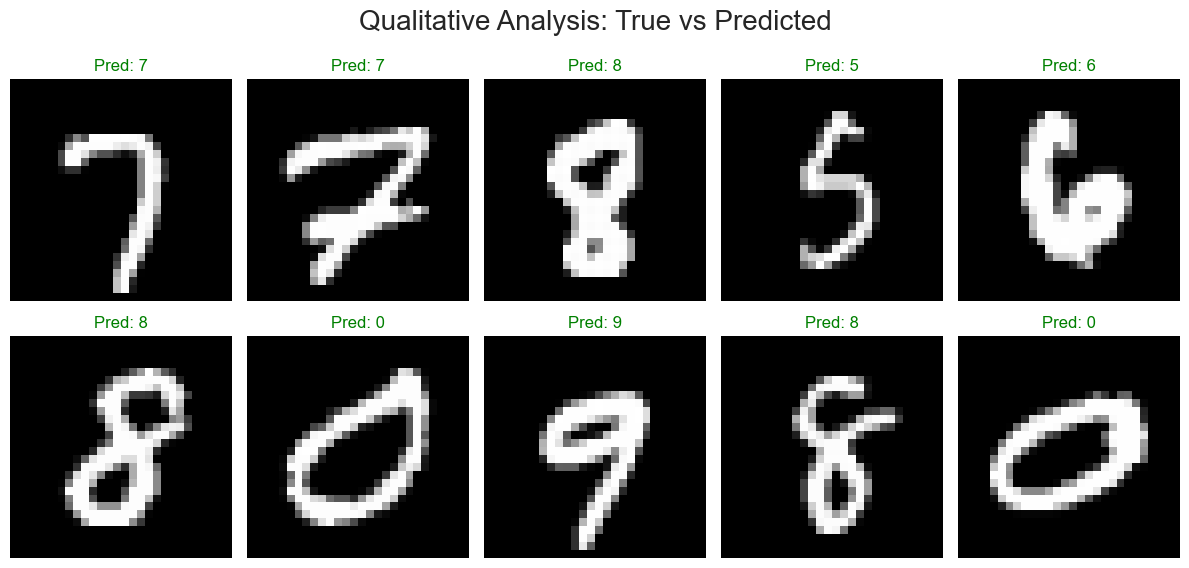

In [14]:
import seaborn as sns
from sklearn.preprocessing import label_binarize
from sklearn.metrics import confusion_matrix, roc_curve, auc

num_samples = 10
indices = np.random.choice(len(X_test_proc), num_samples, replace=False)

fig, axes = plt.subplots(2, 5, figsize=(12, 6))
fig.suptitle('Qualitative Analysis: True vs Predicted', fontsize=20)

for i, ax in enumerate(axes.flat):
    idx = indices[i]
    img = X_test[idx].reshape(28, 28) 
    
    pred_label = model.predict(X_test_proc[idx].reshape(1, -1))[0]
    
    true_label = y_test[idx]
    
    ax.imshow(img, cmap='grey')
    ax.set_title(f"Pred: {pred_label}", 
                 color=('green' if pred_label == true_label else 'red'))
    ax.axis('off')

plt.tight_layout()
plt.show()

Text(0.5, 38.72222222222221, 'Predicted Label')

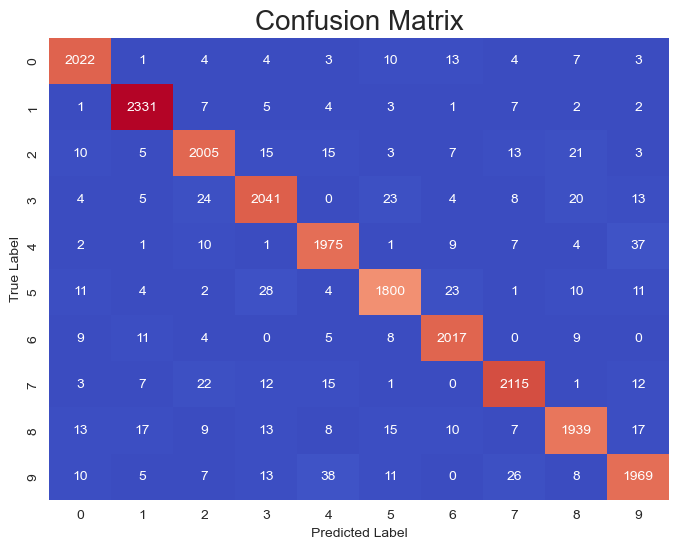

In [23]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='coolwarm', cbar=False)
plt.title('Confusion Matrix', fontsize=20)
plt.ylabel('True Label')
plt.xlabel('Predicted Label')


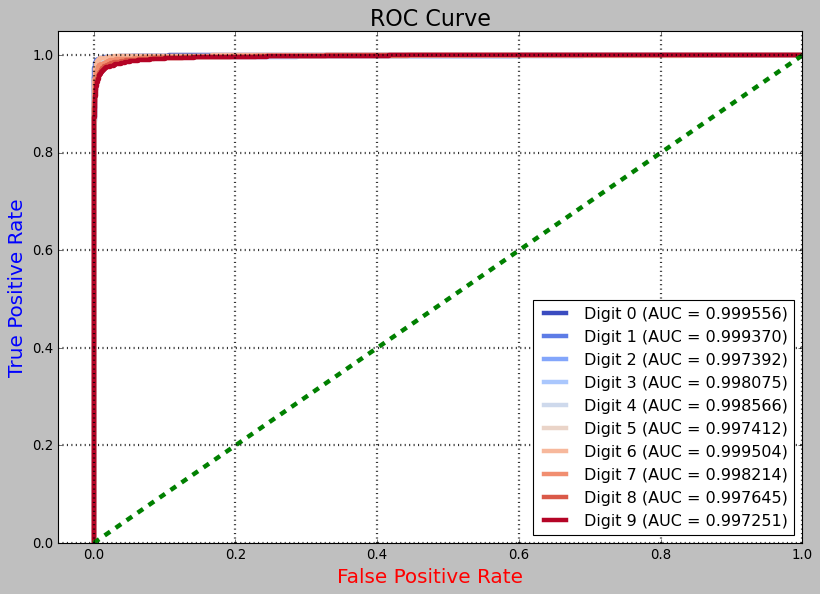

In [16]:
y_test_bin = label_binarize(y_test, classes=clf.classes_)
y_score = clf.predict_proba(X_test_proc)
n_classes = y_test_bin.shape[1]

with plt.style.context('classic'):
    plt.figure(figsize=(12, 8))
    colors = plt.get_cmap('coolwarm', n_classes)
    
    for i in range(n_classes):
        fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_score[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, color=colors(i), lw=4, label=f'Digit {i} (AUC = {roc_auc:.6f})')
    plt.ylim(0, 1.05)
    plt.xlim(-0.05, 1.0)
    plt.plot([0, 1], [0, 1], 'g--',lw=4)
    plt.title('ROC Curve', fontsize=20)
    plt.xlabel('False Positive Rate', fontsize =18, color='r')
    plt.ylabel('True Positive Rate', fontsize =18, color='b')
    plt.legend(loc="lower right")
    plt.grid(alpha=0.8, axis="both",color ='k',lw=2)
    plt.show()